In [1]:
import os
import json
from PIL import Image
import torch
import torchvision.transforms as T
import torchvision
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
# Paths to folders
image_folder = "/content/drive/MyDrive/DL Project/Pics/images"
mask_folder = "/content/drive/MyDrive/DL Project/Pics/annotation_mask"
model_save_path = "/content/drive/MyDrive/DL Project/best_model.pth"
device = torch.device("cuda")


In [4]:
label_colors = {
    "background": (0, 0, 0),          # Black for background
    "grilled chicken": (255, 0, 0),   # Red
    "paneer": (0, 255, 0),            # Green
    "eggplant": (0, 0, 255)           # Blue
}


In [5]:
# Convert RGB colors to class indices
color_to_class = {v: i for i, (k, v) in enumerate(label_colors.items())}

In [6]:
# Custom Dataset Class
class FoodSegmentationDataset(Dataset):
    def __init__(self, image_dir, mask_dir, transform=None):
        self.image_dir = image_dir
        self.mask_dir = mask_dir
        self.transform = transform
        self.images = [f for f in os.listdir(image_dir) if f.endswith('.png')]

    def __len__(self):
        return len(self.images)

    def __getitem__(self, idx):
        img_name = self.images[idx]
        img_path = os.path.join(self.image_dir, img_name)
        mask_path = os.path.join(self.mask_dir, img_name)

        # Load image and mask
        image = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path).convert("RGB")

        # Convert mask to class indices
        mask = self.rgb_to_class_indices(mask)

        if self.transform:
            image = self.transform(image)
            mask = torch.tensor(mask, dtype=torch.long)

        return image, mask

    def rgb_to_class_indices(self, mask):
        mask_np = np.array(mask)
        class_mask = np.zeros((mask_np.shape[0], mask_np.shape[1]), dtype=np.int64)
        for color, class_idx in color_to_class.items():
            class_mask[(mask_np == color).all(axis=2)] = class_idx
        return class_mask

In [7]:
# Data transformations
transform = T.Compose([
    T.Resize((512, 512)),
    T.ToTensor(),
])

In [8]:
# Create Dataset and DataLoader
dataset = FoodSegmentationDataset(image_folder, mask_folder, transform=transform)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = torch.utils.data.random_split(dataset, [train_size, val_size])
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)

In [9]:
# Load EfficientNet-B0 and modify for segmentation
class EfficientNetSegmentation(nn.Module):
    def __init__(self, num_classes):
        super(EfficientNetSegmentation, self).__init__()
        self.backbone = torchvision.models.efficientnet_b0(pretrained=True).features
        self.upsample = nn.Sequential(
            nn.Conv2d(1280, num_classes, kernel_size=1),
            nn.Upsample(size=(512, 512), mode='bilinear', align_corners=False)
        )

        # Freeze all layers in the backbone
        for param in self.backbone.parameters():
            param.requires_grad = False

    def forward(self, x):
        x = self.backbone(x)
        x = self.upsample(x)
        return x

In [10]:
# Initialize the model with the number of classes
model = EfficientNetSegmentation(num_classes=len(label_colors))


Downloading: "https://download.pytorch.org/models/efficientnet_b0_rwightman-7f5810bc.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b0_rwightman-7f5810bc.pth
100%|██████████| 20.5M/20.5M [00:00<00:00, 120MB/s] 


In [11]:
class_weights = torch.tensor([0.05, 1.0, 1.0, 1.0]).to(device)
criterion = nn.CrossEntropyLoss(weight=class_weights)
optimizer = optim.Adam(model.upsample.parameters(), lr=0.001)

In [12]:
# IoU Calculation Function
def calculate_iou(preds, targets, num_classes):
    ious = []
    for cls in range(num_classes):
        intersection = ((preds == cls) & (targets == cls)).sum().item()
        union = ((preds == cls) | (targets == cls)).sum().item()
        if union > 0:
            ious.append(intersection / union)
    return np.nanmean(ious) if ious else float('nan')

In [13]:
# Training function
def train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=20):
    model = model.to(device)

    train_losses = []
    val_losses = []
    iou_scores = []
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        epoch_iou = 0
        total_batches = 0

        for images, masks in train_loader:
            images, masks = images.to(device), masks.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, masks)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            preds = outputs.argmax(1)
            epoch_iou += calculate_iou(preds, masks, len(label_colors))
            total_batches += 1

        epoch_iou /= total_batches
        iou_scores.append(epoch_iou)

        # Validation
        model.eval()
        val_loss = 0
        with torch.no_grad():
            for images, masks in val_loader:
                images, masks = images.to(device), masks.to(device)
                outputs = model(images)
                loss = criterion(outputs, masks)
                val_loss += loss.item()

        val_loss /= len(val_loader)
        train_losses.append(train_loss / len(train_loader))
        val_losses.append(val_loss)

        # Save model if it has the best validation loss
        if val_loss < best_val_loss:
            best_val_loss = val_loss
            torch.save(model.state_dict(), model_save_path)
            print(f"Epoch {epoch+1}: Saved new best model with validation loss {best_val_loss}")

        print(f"Epoch {epoch+1}/{num_epochs}, Training Loss: {train_losses[-1]}, Validation Loss: {val_losses[-1]}, IoU: {epoch_iou}")

    # Plotting the Training and Validation Loss per Epoch
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, num_epochs + 1), train_losses, label="Training Loss")
    plt.plot(range(1, num_epochs + 1), val_losses, label="Validation Loss")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.title("Training and Validation Loss per Epoch")
    plt.legend()
    plt.show()

    # Plotting the IoU per Epoch
    plt.figure(figsize=(12, 5))
    plt.plot(range(1, num_epochs + 1), iou_scores, label="IoU")
    plt.xlabel("Epochs")
    plt.ylabel("IoU")
    plt.title("IoU per Epoch")
    plt.legend()
    plt.show()

In [14]:
# Load the best model for evaluation
def load_best_model(model, model_save_path):
    model.load_state_dict(torch.load(model_save_path))
    model.eval()
    print("Loaded best model with lowest validation loss.")

In [15]:
# Visualization function
def visualize_predictions(model, dataloader):
    model.eval()
    with torch.no_grad():
        for images, masks in dataloader:
            images = images.to(device)
            outputs = model(images)
            preds = outputs.argmax(1).cpu().numpy()

            for i in range(len(images)):
                pred_rgb = np.zeros((preds[i].shape[0], preds[i].shape[1], 3), dtype=np.uint8)
                mask_rgb = np.zeros((masks[i].shape[0], masks[i].shape[1], 3), dtype=np.uint8)

                for color, class_idx in color_to_class.items():
                    pred_rgb[preds[i] == class_idx] = color
                    mask_rgb[masks[i].cpu().numpy() == class_idx] = color

                unique, counts = np.unique(preds[i], return_counts=True)
                label_name = "background"
                for idx in np.argsort(-counts):
                    if unique[idx] != color_to_class[(0, 0, 0)]:
                        label_name = list(label_colors.keys())[unique[idx]]
                        break

                title_text = f"Prediction: {label_name}"

                # Plot the images
                fig, axs = plt.subplots(1, 3, figsize=(15, 5))
                axs[0].imshow(images[i].cpu().permute(1, 2, 0))
                axs[0].set_title("Input Image")
                axs[1].imshow(mask_rgb)
                axs[1].set_title("Ground Truth Mask")
                axs[2].imshow(pred_rgb)
                axs[2].set_title(title_text)
                plt.show()
                break

Epoch 1: Saved new best model with validation loss 0.725437867641449
Epoch 1/50, Training Loss: 1.0255371034145355, Validation Loss: 0.725437867641449, IoU: 0.19449700387310515
Epoch 2: Saved new best model with validation loss 0.5931649327278137
Epoch 2/50, Training Loss: 0.6997527569532395, Validation Loss: 0.5931649327278137, IoU: 0.23222318580973428
Epoch 3: Saved new best model with validation loss 0.5659200489521027
Epoch 3/50, Training Loss: 0.6494209349155426, Validation Loss: 0.5659200489521027, IoU: 0.272604311996293
Epoch 4: Saved new best model with validation loss 0.5446248471736908
Epoch 4/50, Training Loss: 0.559652017056942, Validation Loss: 0.5446248471736908, IoU: 0.27993475628723163
Epoch 5: Saved new best model with validation loss 0.536723530292511
Epoch 5/50, Training Loss: 0.5690743505954743, Validation Loss: 0.536723530292511, IoU: 0.3044581461559862
Epoch 6/50, Training Loss: 0.5330363854765892, Validation Loss: 0.5409147262573242, IoU: 0.3009335354965435
Epoch

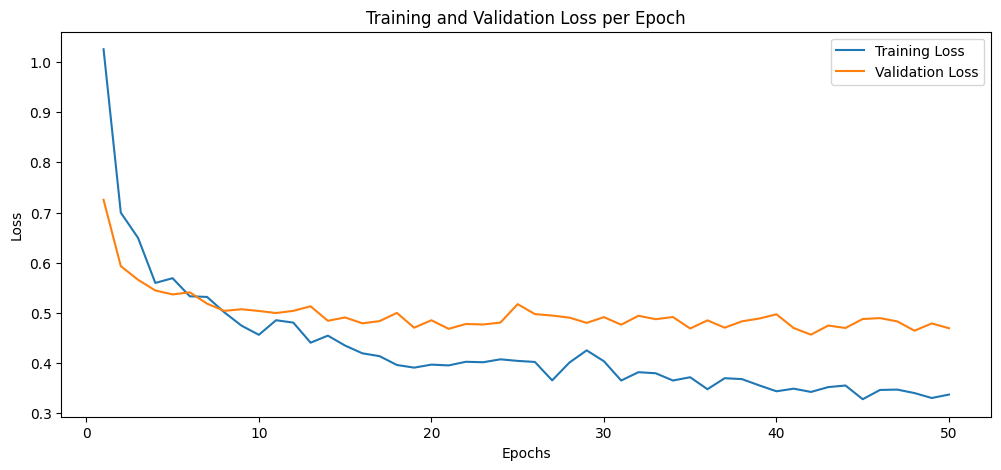

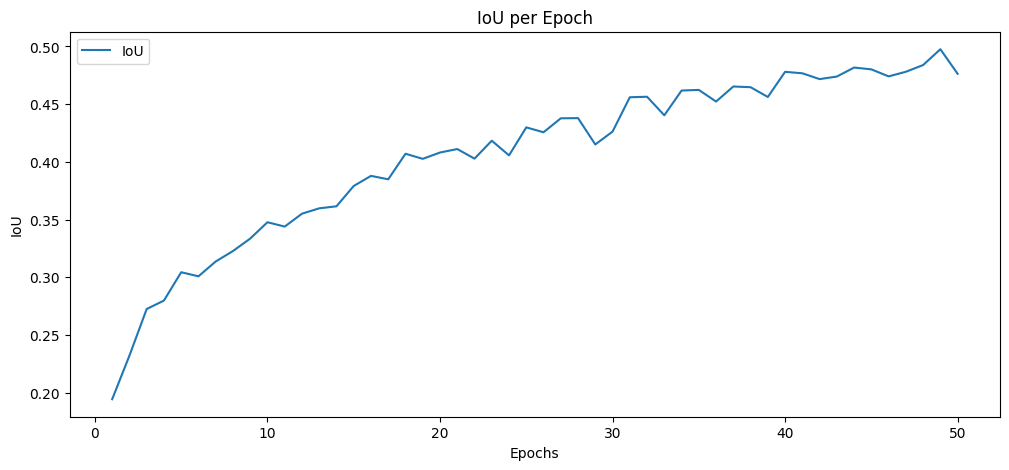

In [16]:
# Initialize and train the model
train_model(model, train_loader, val_loader, criterion, optimizer, num_epochs=50)

In [17]:
# Load the best model
load_best_model(model, model_save_path)


Loaded best model with lowest validation loss.


In [18]:
# Calculate IoU for the best model
def calculate_iou_for_best_model(model, val_loader):
    model.eval()
    total_iou = 0
    total_batches = 0

    with torch.no_grad():
        for images, masks in val_loader:
            images, masks = images.to(device), masks.to(device)
            outputs = model(images)
            preds = outputs.argmax(1)
            total_iou += calculate_iou(preds, masks, len(label_colors))
            total_batches += 1

    best_model_iou = total_iou / total_batches
    print(f"IoU for the Best Model: {best_model_iou}")

calculate_iou_for_best_model(model, val_loader)

IoU for the Best Model: 0.48958006555793104


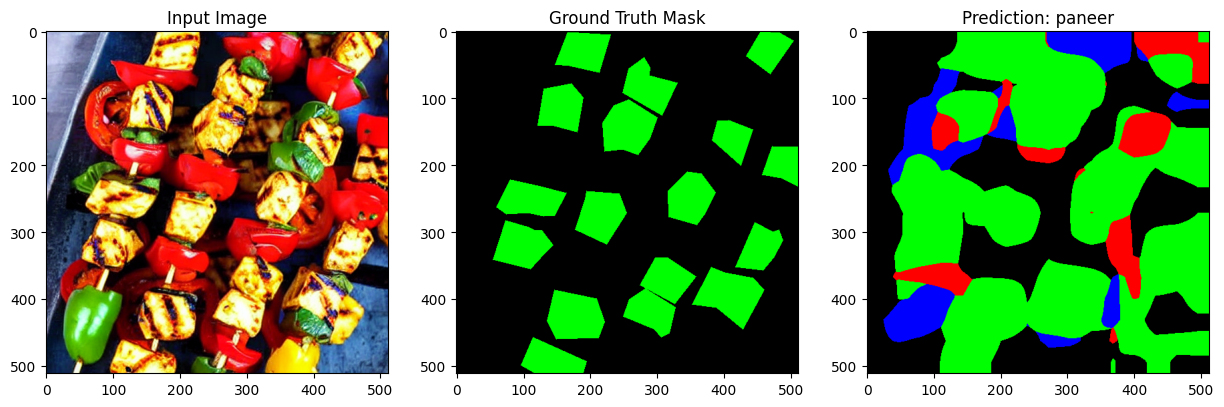

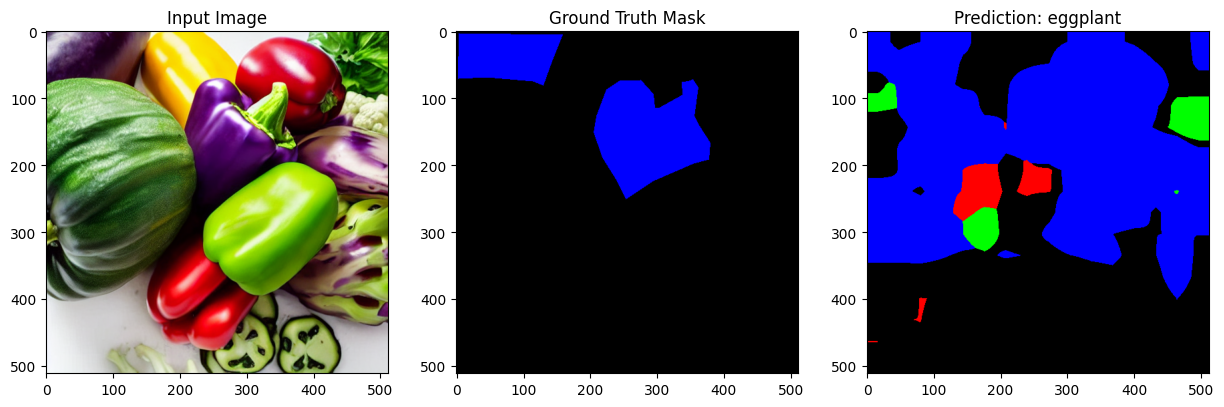

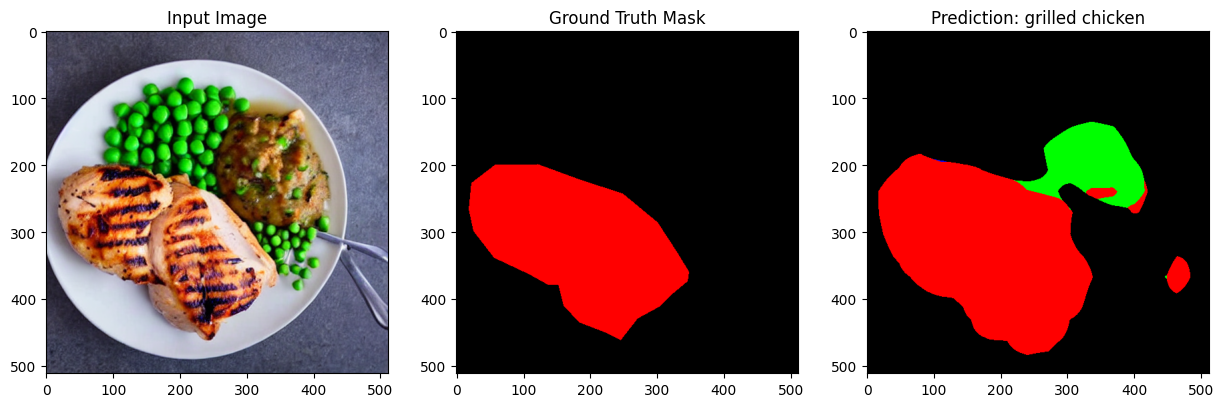

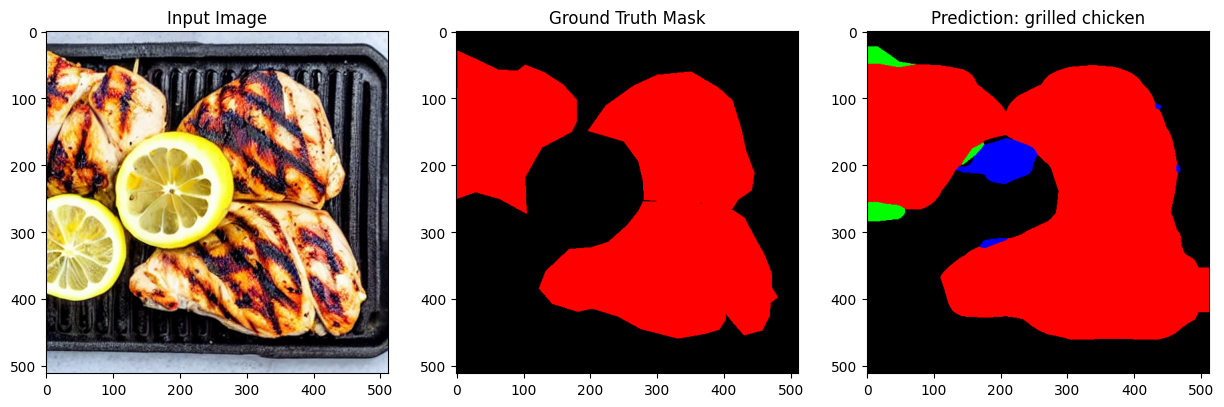

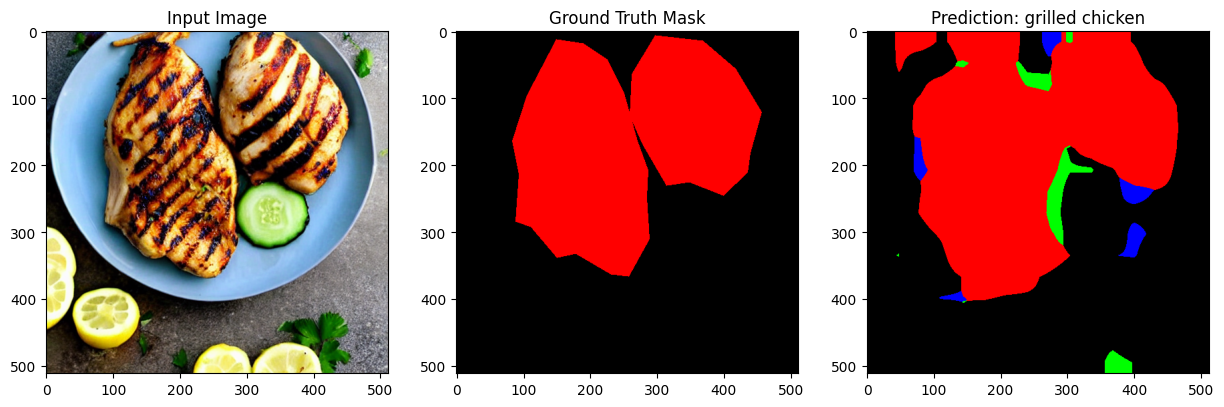

In [19]:
# Visualize the best model
visualize_predictions(model, val_loader)